In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import time

In [2]:
# Step 1: Load the Dataset
data_path = 'user_behavior_dataset.csv'
data = pd.read_csv(data_path)

### Step 2: Inspect and Clean the Data


In [3]:
print("Dataset Overview:")
data.head()

Dataset Overview:


,User ID,Device Model,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Gender,User Behavior Class
0,1,Google Pixel 5,Android,393,6.4,1872,67,1122,40,Male,4
1,2,OnePlus 9,Android,268,4.7,1331,42,944,47,Female,3
2,3,Xiaomi Mi 11,Android,154,4.0,761,32,322,42,Male,2
3,4,Google Pixel 5,Android,239,4.8,1676,56,871,20,Male,3
4,5,iPhone 12,iOS,187,4.3,1367,58,988,31,Female,3


In [4]:
print("\nDataset Info:")
print(data.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   User ID                     700 non-null    int64  
 1   Device Model                700 non-null    object 
 2   Operating System            700 non-null    object 
 3   App Usage Time (min/day)    700 non-null    int64  
 4   Screen On Time (hours/day)  700 non-null    float64
 5   Battery Drain (mAh/day)     700 non-null    int64  
 6   Number of Apps Installed    700 non-null    int64  
 7   Data Usage (MB/day)         700 non-null    int64  
 8   Age                         700 non-null    int64  
 9   Gender                      700 non-null    object 
 10  User Behavior Class         700 non-null    int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 60.3+ KB
None


In [5]:
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
User ID                       0
Device Model                  0
Operating System              0
App Usage Time (min/day)      0
Screen On Time (hours/day)    0
Battery Drain (mAh/day)       0
Number of Apps Installed      0
Data Usage (MB/day)           0
Age                           0
Gender                        0
User Behavior Class           0
dtype: int64


In [6]:
# Remove rows with missing values (if present above)
data = data.dropna()

In [7]:
# Renaming columns for consistency and brevity
data = data.rename(columns={
    'User ID': 'user_id',
    'App Usage Time (min/day)': 'app_usage',
    'Screen On Time (hours/day)': 'screen_time',
    'Number of Apps Installed': 'num_apps'
})
data.head()

,user_id,Device Model,Operating System,app_usage,screen_time,Battery Drain (mAh/day),num_apps,Data Usage (MB/day),Age,Gender,User Behavior Class
0,1,Google Pixel 5,Android,393,6.4,1872,67,1122,40,Male,4
1,2,OnePlus 9,Android,268,4.7,1331,42,944,47,Female,3
2,3,Xiaomi Mi 11,Android,154,4.0,761,32,322,42,Male,2
3,4,Google Pixel 5,Android,239,4.8,1676,56,871,20,Male,3
4,5,iPhone 12,iOS,187,4.3,1367,58,988,31,Female,3


### Step 3: Feature Engineering


In [8]:
# Calculate the total screen-on time in minutes per user
# data['screen_time'] = data['screen_time'].astype(float)
data['screen_time'] = data['screen_time'] * 60  # Convert hours to minutes
data['screen_time'].unique()

array([384., 282., 240., 288., 258., 120., 438., 684., 462., 396.,  84.,
       330., 372., 294., 324., 624., 216., 348., 510., 156., 696., 390.,
       336., 204., 456., 630., 408., 360., 276., 612.,  72., 198., 672.,
       606., 126., 222., 144., 654., 504., 492., 522., 444., 354., 162.,
       132.,  96.,  66., 420., 426., 714., 450., 114., 690., 270., 102.,
       432., 540., 378., 342., 150., 108., 636., 168.,  90., 246., 570.,
       720., 252., 228., 516., 306., 192., 474., 312., 600., 486., 708.,
       648.,  60., 678., 582., 666., 318., 564., 468., 552., 642., 264.,
       534.,  78., 186., 558., 366., 414., 576., 138., 702., 210., 300.,
       174., 180., 498., 588., 618., 234., 528., 546., 402.])

In [9]:
# Calculate the number of apps per user
# apps_per_user = data.groupby('user_id')['app_name'].nunique().reset_index()
# apps_per_user.columns = ['user_id', 'num_apps']
apps_per_user = data[['user_id', 'num_apps']].drop_duplicates()

In [10]:
# Calculate the total screen-on time per user
screen_time_per_user = data.groupby('user_id')['screen_time'].sum().reset_index()
screen_time_per_user.columns = ['user_id', 'total_screen_time']
screen_time_per_user.head()

,user_id,total_screen_time
0,1,384.0
1,2,282.0
2,3,240.0
3,4,288.0
4,5,258.0


In [11]:
# Merge the two datasets
user_data = pd.merge(apps_per_user, screen_time_per_user, on='user_id')
user_data.head()

,user_id,num_apps,total_screen_time
0,1,67,384.0
1,2,42,282.0
2,3,32,240.0
3,4,56,288.0
4,5,58,258.0


### Step 4: Exploratory Data Analysis


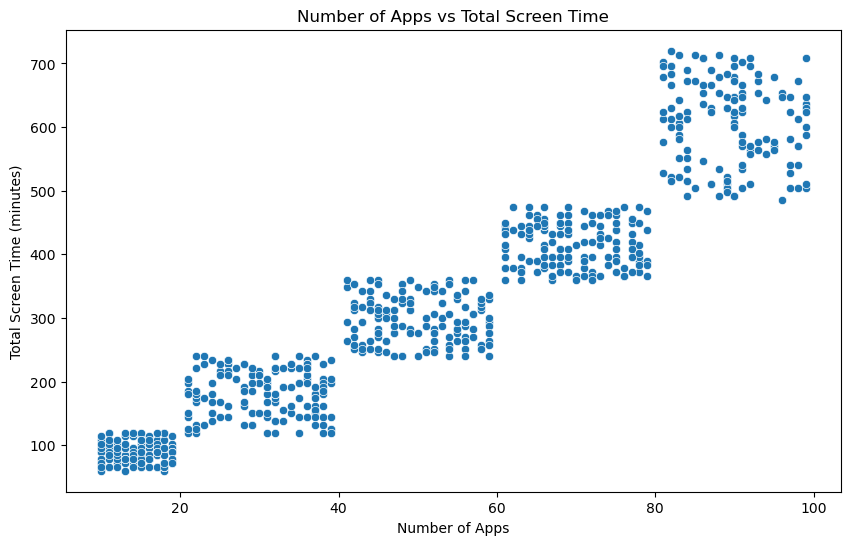

In [12]:
# Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=user_data, x='num_apps', y='total_screen_time')
plt.title('Number of Apps vs Total Screen Time')
plt.xlabel('Number of Apps')
plt.ylabel('Total Screen Time (minutes)')
plt.show()

In [13]:
# Investigate unique values of total_screen_time
print("\nUnique Total Screen Time Values:")
print(user_data['total_screen_time'].unique())


Unique Total Screen Time Values:
[384. 282. 240. 288. 258. 120. 438. 684. 462. 396.  84. 330. 372. 294.
 324. 624. 216. 348. 510. 156. 696. 390. 336. 204. 456. 630. 408. 360.
 276. 612.  72. 198. 672. 606. 126. 222. 144. 654. 504. 492. 522. 444.
 354. 162. 132.  96.  66. 420. 426. 714. 450. 114. 690. 270. 102. 432.
 540. 378. 342. 150. 108. 636. 168.  90. 246. 570. 720. 252. 228. 516.
 306. 192. 474. 312. 600. 486. 708. 648.  60. 678. 582. 666. 318. 564.
 468. 552. 642. 264. 534.  78. 186. 558. 366. 414. 576. 138. 702. 210.
 300. 174. 180. 498. 588. 618. 234. 528. 546. 402.]


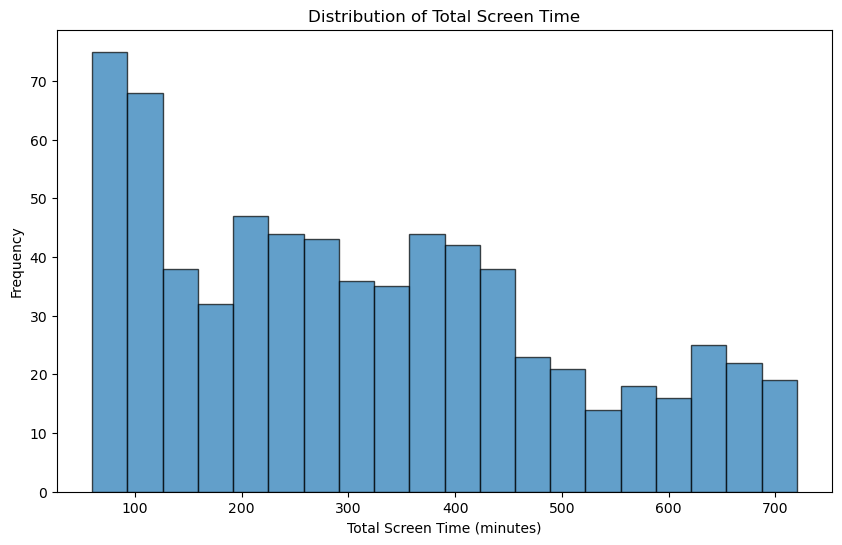

In [14]:
# Plot histogram to visualize the distribution of total_screen_time
plt.figure(figsize=(10, 6))
plt.hist(user_data['total_screen_time'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribution of Total Screen Time')
plt.xlabel('Total Screen Time (minutes)')
plt.ylabel('Frequency')
plt.show()

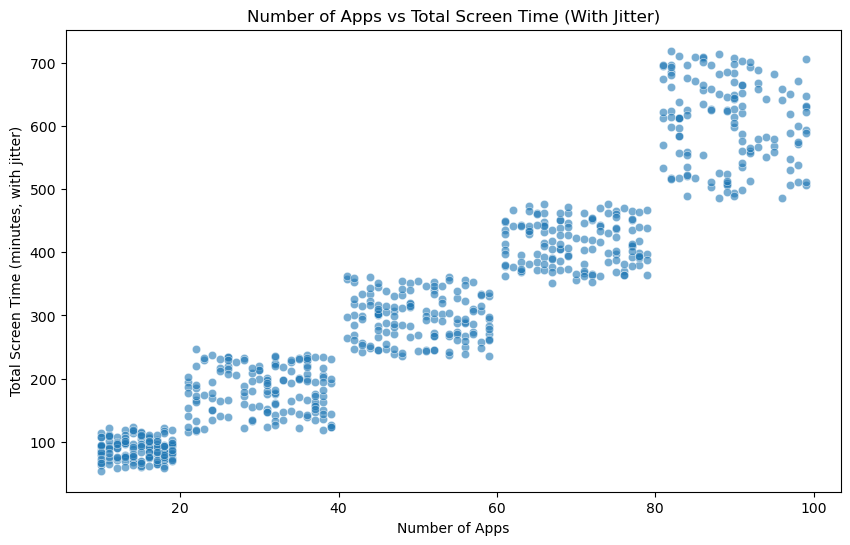

In [15]:
# Add jitter to the data for better visualization
user_data['total_screen_time_jittered'] = user_data['total_screen_time'] + np.random.normal(0, 5, size=user_data.shape[0])

plt.figure(figsize=(10, 6))
sns.scatterplot(data=user_data, x='num_apps', y='total_screen_time_jittered', alpha=0.6)
plt.title('Number of Apps vs Total Screen Time (With Jitter)')
plt.xlabel('Number of Apps')
plt.ylabel('Total Screen Time (minutes, with jitter)')
plt.show()

### Step 5: Correlation Matrix


In [16]:
# Calculate correlation coefficients
pearson_corr, pearson_pval = pearsonr(user_data['num_apps'], user_data['total_screen_time'])
spearman_corr, spearman_pval = spearmanr(user_data['num_apps'], user_data['total_screen_time'])

print(f"Pearson Correlation: {pearson_corr:.2f} (p-value: {pearson_pval:.3f})")
print(f"Spearman Correlation: {spearman_corr:.2f} (p-value: {spearman_pval:.3f})")

Pearson Correlation: 0.95 (p-value: 0.000)
Spearman Correlation: 0.96 (p-value: 0.000)


### Step 6: Linear Regression


In [17]:
# Linear Regression
# Prepare the data
X = user_data[['num_apps']]
Y = user_data['total_screen_time']

# Fit the model
model = LinearRegression()
model.fit(X, Y)

# Predictions and Evaluation
predictions = model.predict(X)
rmse = np.sqrt(mean_squared_error(Y, predictions))
r2 = r2_score(Y, predictions)

print(f"\nLinear Regression Model:")
print(f"Coefficient: {model.coef_[0]:.2f}")
print(f"Intercept: {model.intercept_:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R^2 Score: {r2:.2f}")


Linear Regression Model:
Coefficient: 6.47
Intercept: -11.60
RMSE: 59.12
R^2 Score: 0.90


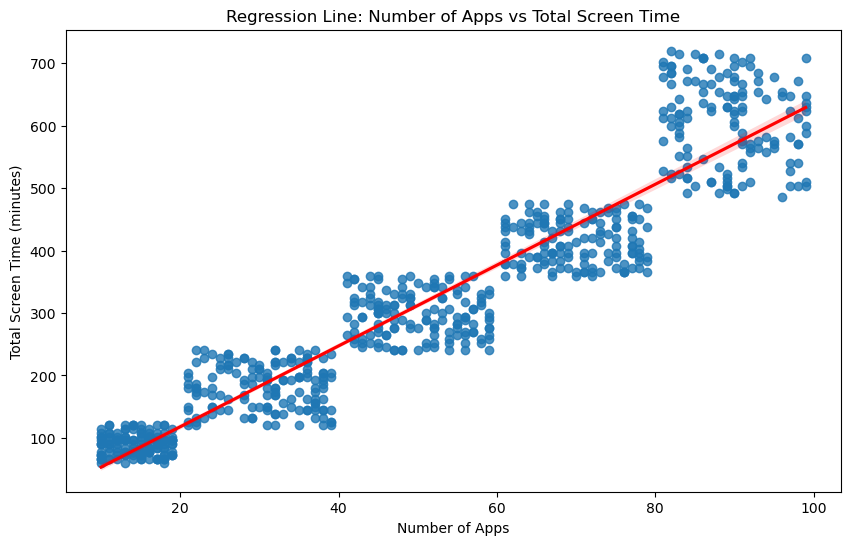

In [18]:
# Regression Line
plt.figure(figsize=(10, 6))
sns.regplot(data=user_data, x='num_apps', y='total_screen_time', line_kws={'color': 'red'})
plt.title('Regression Line: Number of Apps vs Total Screen Time')
plt.xlabel('Number of Apps')
plt.ylabel('Total Screen Time (minutes)')
plt.show()

### Step 7: Predictive Modeling


In [19]:
# Prepare the data
X = user_data[['num_apps']]
Y = user_data['total_screen_time']

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, Y_train)

# Predictions on test data
linear_predictions = linear_model.predict(X_test)

# Evaluate the model
linear_rmse = np.sqrt(mean_squared_error(Y_test, linear_predictions))
linear_r2 = r2_score(Y_test, linear_predictions)

print(f"\nLinear Regression Model:")
print(f"Coefficient: {linear_model.coef_[0]:.2f}")
print(f"Intercept: {linear_model.intercept_:.2f}")
print(f"RMSE: {linear_rmse:.2f}")
print(f"R^2 Score: {linear_r2:.2f}")


Linear Regression Model:
Coefficient: 6.43
Intercept: -10.67
RMSE: 63.98
R^2 Score: 0.87



Random Forest Regression Model:
RMSE: 45.14
R^2 Score: 0.94


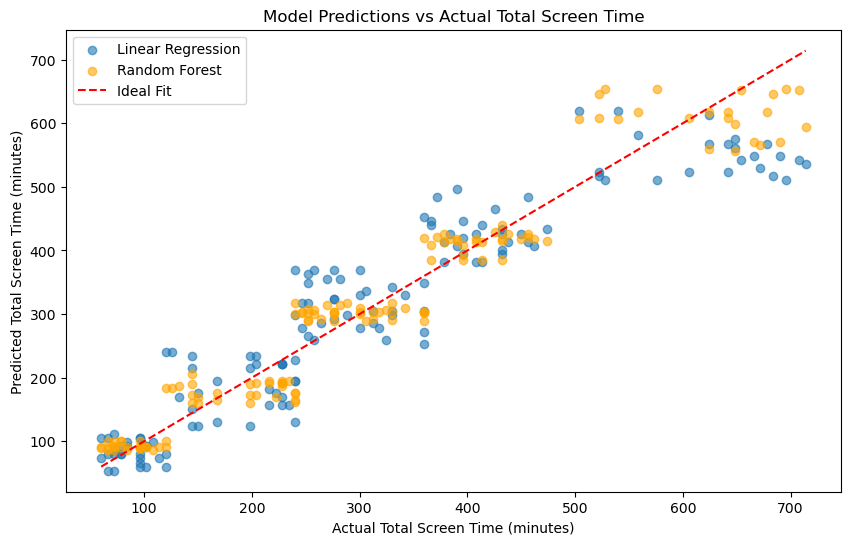

In [20]:
# Random Forest Regression
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train, Y_train)

# Predictions
rf_predictions = rf_model.predict(X_test)

# Evaluate Random Forest
rf_rmse = np.sqrt(mean_squared_error(Y_test, rf_predictions))
rf_r2 = r2_score(Y_test, rf_predictions)

print(f"\nRandom Forest Regression Model:")
print(f"RMSE: {rf_rmse:.2f}")
print(f"R^2 Score: {rf_r2:.2f}")

# Plot predictions for both models
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, linear_predictions, alpha=0.6, label='Linear Regression')
plt.scatter(Y_test, rf_predictions, alpha=0.6, label='Random Forest', color='orange')
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linestyle='--', label='Ideal Fit')
plt.title('Model Predictions vs Actual Total Screen Time')
plt.xlabel('Actual Total Screen Time (minutes)')
plt.ylabel('Predicted Total Screen Time (minutes)')
plt.legend()
plt.show()



Linear Regression Model:
Coefficient: 6.43
Intercept: -10.67
RMSE: 63.98
R^2 Score: 0.87
Time Taken: 0.0010 seconds

Random Forest Regression Model:
RMSE: 45.14
R^2 Score: 0.94
Time Taken: 0.0740 seconds

Benchmark Comparison:
Linear Regression - RMSE: 63.98, R^2: 0.87, Time: 0.0010s
Random Forest - RMSE: 45.14, R^2: 0.94, Time: 0.0740s


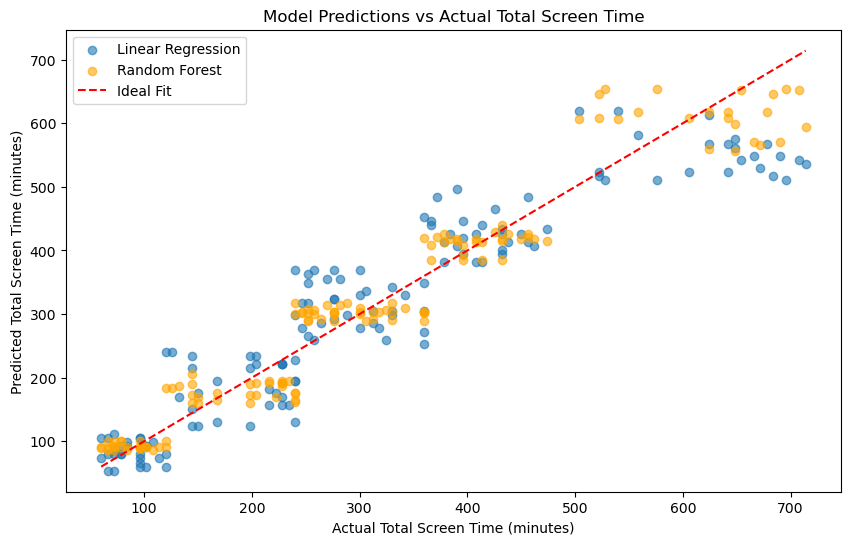

In [21]:
# Prepare the data
X = user_data[['num_apps']]
Y = user_data['total_screen_time']

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Linear Regression Benchmark
start_time_linear = time.time()
linear_model = LinearRegression()
linear_model.fit(X_train, Y_train)
linear_end_time = time.time()

# Predictions
linear_predictions = linear_model.predict(X_test)

# Evaluate Linear Regression
linear_rmse = np.sqrt(mean_squared_error(Y_test, linear_predictions))
linear_r2 = r2_score(Y_test, linear_predictions)
linear_time_taken = linear_end_time - start_time_linear

print(f"\nLinear Regression Model:")
print(f"Coefficient: {linear_model.coef_[0]:.2f}")
print(f"Intercept: {linear_model.intercept_:.2f}")
print(f"RMSE: {linear_rmse:.2f}")
print(f"R^2 Score: {linear_r2:.2f}")
print(f"Time Taken: {linear_time_taken:.4f} seconds")

# Random Forest Benchmark
start_time_rf = time.time()
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train, Y_train)
rf_end_time = time.time()

# Predictions
rf_predictions = rf_model.predict(X_test)

# Evaluate Random Forest
rf_rmse = np.sqrt(mean_squared_error(Y_test, rf_predictions))
rf_r2 = r2_score(Y_test, rf_predictions)
rf_time_taken = rf_end_time - start_time_rf

print(f"\nRandom Forest Regression Model:")
print(f"RMSE: {rf_rmse:.2f}")
print(f"R^2 Score: {rf_r2:.2f}")
print(f"Time Taken: {rf_time_taken:.4f} seconds")

# Benchmark Comparison
print("\nBenchmark Comparison:")
print(f"Linear Regression - RMSE: {linear_rmse:.2f}, R^2: {linear_r2:.2f}, Time: {linear_time_taken:.4f}s")
print(f"Random Forest - RMSE: {rf_rmse:.2f}, R^2: {rf_r2:.2f}, Time: {rf_time_taken:.4f}s")

# Plot predictions for both models
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, linear_predictions, alpha=0.6, label='Linear Regression')
plt.scatter(Y_test, rf_predictions, alpha=0.6, label='Random Forest', color='orange')
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linestyle='--', label='Ideal Fit')
plt.title('Model Predictions vs Actual Total Screen Time')
plt.xlabel('Actual Total Screen Time (minutes)')
plt.ylabel('Predicted Total Screen Time (minutes)')
plt.legend()
plt.show()

### Step 7: Conclusion


In [22]:
print("\nDiscussion:")
print("The analysis compared Linear Regression and Random Forest Regression for predicting screen time.")
print("Linear Regression is interpretable but assumes a linear relationship, while Random Forest captures potential non-linearities.")
print("Based on RMSE and R^2 scores, the model with the best performance can be selected.")


Discussion:
The analysis compared Linear Regression and Random Forest Regression for predicting screen time.
Linear Regression is interpretable but assumes a linear relationship, while Random Forest captures potential non-linearities.
Based on RMSE and R^2 scores, the model with the best performance can be selected.
